In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

In [9]:
df = pd.read_csv('data/df_hw.csv', index_col='user_id')
df = df.drop(['Unnamed: 0'], axis=1)

In [12]:
set(df[df.day < 10].index) == set(df[df.day >= 10].index)

True

In [13]:
df.groupby('day').count()

,metric
day,
0,1000
1,1000
2,1000
3,1000
4,1000
5,1000
6,1000
7,1000
8,1000


Магазин у нас небольшой, и А/Б тест делаем, чтобы проверить стоит ли внедрять модель на долгий срок.
А за короткое время проведения АБ теста модель не сможет привести к большим потерям, так что можем позволить применить модель для половины клиентов.

Первые 10 дней наблюдений сделаем трейном -- будем на них подбирать разбияние, а на остальных 10 днях проведем А/А тест. 

In [14]:
df_train_all = df[df.day < 10]
df_val_all = df[df.day >= 10]

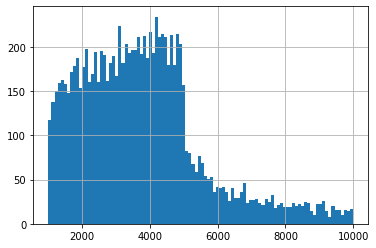

In [16]:
df_train_all.metric.hist(bins=100);

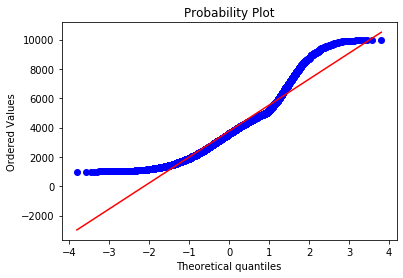

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
res=scipy.stats.probplot(df_train_all.metric, plot=ax);

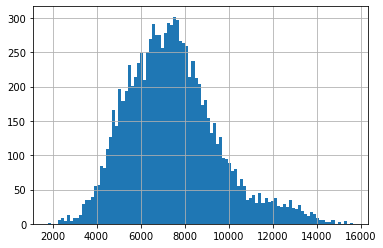

In [19]:
df_val_all.metric.hist(bins=100);

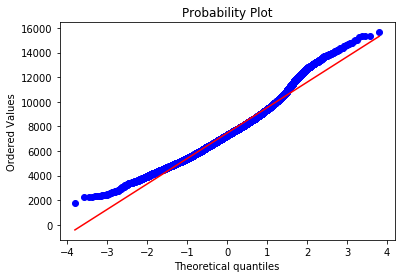

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
res=scipy.stats.probplot(df_val_all.metric, plot=ax);

Выборки распределены не нормально -- будем применять непараметрические критерии.

In [21]:
user_ids = df.index.unique()

def random_AB_users_split():
    users_A = np.random.choice(user_ids, size=len(user_ids) // 2, replace=False)
    users_B = np.setdiff1d(user_ids, users_A)
    return users_A, users_B

In [22]:
def plot_splitting(df_train_A, df_train_B, df_val_A, df_val_B):
    plt.figure(figsize=(10,6))
    train_A_per_day_avg = df_train_A.groupby('day').mean().metric
    train_B_per_day_avg = df_train_B.groupby('day').mean().metric
    val_A_per_day_avg = df_val_A.groupby('day').mean().metric
    val_B_per_day_avg = df_val_B.groupby('day').mean().metric
    plt.plot(train_A_per_day_avg.index, train_A_per_day_avg, label='train A')
    plt.plot(train_B_per_day_avg.index, train_B_per_day_avg, label='train B')    
    plt.plot(val_A_per_day_avg.index, val_A_per_day_avg, label='val A')    
    plt.plot(val_B_per_day_avg.index, val_B_per_day_avg, label='val B')
    plt.ylabel('Avg check')
    plt.xlabel('day')
    plt.legend()
    plt.show()

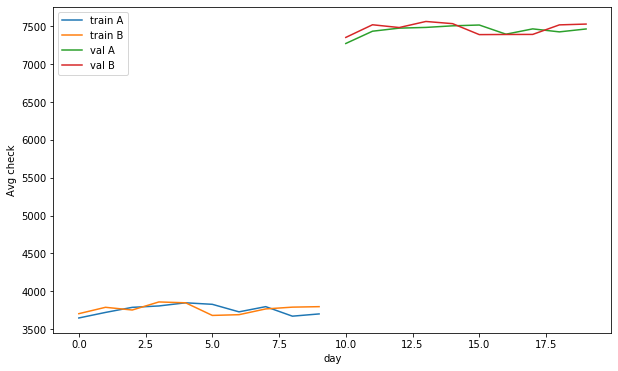

In [23]:
users_A, users_B = random_AB_users_split()

plot_splitting(df_train_all.loc[users_A], df_train_all.loc[users_B], 
               df_val_all.loc[users_A], df_val_all.loc[users_B])

Проверим корректность рандомного разбиения по клиентам и применения критерия Манна-Уитни.

In [188]:
iters = 5000

p_values = []

for i in range(iters):
    users_A, users_B = random_AB_users_split()
    val_A, val_B = df_val_all.loc[users_A].metric, df_val_all.loc[users_B].metric
    p_ans = scipy.stats.mannwhitneyu(val_A, val_B, alternative='two-sided').pvalue
    p_values.append(p_ans)

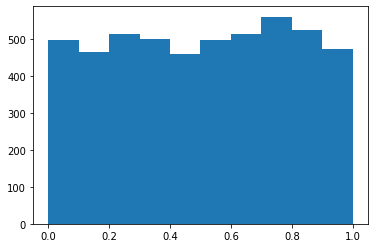

In [189]:
plt.hist(p_values, bins=10);

Ок, p-value распределен равномерно.

**А/А тест:**

Клиентов разбиваем на две равные группы рандомно, и оставляем разбиение, при котором группы похожи: p-value согласно критериям Манна-Уитни и Колмогорова-Смирнова более 0.2, средние отличаются менее, чем на 1000.

Метрика -- средний чек. Для детектирования различия средних значений метрики в группах используем на валидационых выборках критерий Манна-Уитни.

In [248]:
iters = 5000

p_values = []
similar_groups = []

for i in range(iters):
    users_A, users_B = random_AB_users_split()
    train_A, train_B = df_train_all.loc[users_A].metric, df_train_all.loc[users_B].metric
    
    p_k2s = scipy.stats.ks_2samp(train_A, train_B).pvalue
    p_mw = scipy.stats.mannwhitneyu(train_A, train_B, alternative='two-sided').pvalue
    mean = abs(train_A.mean() - train_B.mean())
    
    if p_mw > 0.2 and p_k2s > 0.2 and mean < 1000:
        similar_groups.append([users_A, users_B])
        val_A, val_B = df_val_all.loc[users_A].metric, df_val_all.loc[users_B].metric
        p_ans = scipy.stats.mannwhitneyu(val_A, val_B).pvalue
        p_values.append(p_ans)

In [249]:
# Корректность
p_values = np.array(p_values)
p_values[p_values < 0.05].shape[0] / len(similar_groups)

0.02835538752362949

Схема АБ теста корректна: на А/А тесте при уровне значимости 0.05 эффект детектируется не более чем в 5% случаев.

Найдем мощность критерия Манна-Уитни на выборках размером 5000 и с эффектом 2%:

In [242]:
iters = 4000

p_values = []
similar_groups = []

effect = 1.02

for i in range(iters):
    users_A, users_B = random_AB_users_split()
    train_A, train_B = df_train_all.loc[users_A].metric, df_train_all.loc[users_B].metric
    
    p_k2s = scipy.stats.ks_2samp(train_A, train_B).pvalue
    p_mw = scipy.stats.mannwhitneyu(train_A, train_B, alternative='two-sided').pvalue
    mean = abs(train_A.mean() - train_B.mean())
    
    if p_mw > 0.2 and p_k2s > 0.2 and mean < 1000:
        similar_groups.append([users_A, users_B])
        val_A, val_B = df_val_all.loc[users_A].metric, df_val_all.loc[users_B].metric
        
        val_B = val_B * effect
        
        p_ans = scipy.stats.mannwhitneyu(val_A, val_B).pvalue
        p_values.append(p_ans)

In [231]:
val_A.mean(), val_B.mean()

(7448.991888804862, 7612.518112391366)

In [243]:
p_values = np.array(p_values)
power = p_values[p_values < 0.05].shape[0] / len(similar_groups)
power

0.994413407821229

Найдем мощность для тестов длительностью в разное число дней.

In [28]:
def random_AB_users_split(df):
    user_ids = df.index.unique()
    users_A = np.random.choice(user_ids, size=len(user_ids) // 2, replace=False)
    users_B = np.setdiff1d(user_ids, users_A)
    return users_A, users_B

In [29]:
iters = 1000

effect = 1.02

powers = []


for n_days in range(1, 11):
    df_train_n_days = df_train_all[df_train_all['day'] < n_days]
    df_val_n_days = df_val_all[df_val_all['day'] < 10 + n_days]

    p_values = []
    similar_groups = []

    for i in range(iters):
        users_A, users_B = random_AB_users_split(df_train_n_days)

        train_A, train_B = df_train_n_days.loc[users_A].metric, df_train_n_days.loc[users_B].metric
        p_k2s = scipy.stats.ks_2samp(train_A, train_B).pvalue
        p_mw = scipy.stats.mannwhitneyu(train_A, train_B, alternative='two-sided').pvalue
        mean = abs(train_A.mean() - train_B.mean())

        if p_mw > 0.2 and p_k2s > 0.2 and mean < 1000:
            similar_groups.append([users_A, users_B])
            val_A, val_B = df_val_n_days.loc[users_A].metric, df_val_n_days.loc[users_B].metric
            val_B = val_B * effect
            p_ans = scipy.stats.mannwhitneyu(val_A, val_B).pvalue
            p_values.append(p_ans)

    p_values = np.array(p_values)
    power = p_values[p_values < 0.05].shape[0] / len(similar_groups)
    powers.append(power)

In [31]:
pd.DataFrame({'Длительность теста (дней)': list(range(1, 11)), 'Мощность': powers})

,Длительность теста (дней),Мощность
0,1,0.284404
1,2,0.487838
2,3,0.650587
3,4,0.774590
4,5,0.868742
5,6,0.921516
6,7,0.952448
7,8,0.982240
8,9,0.989086
9,10,0.994702


Ответ на вопрос "Можно ли статистически значимо задетектить эффект в 2%? Если можно, то за какую длительность теста?": да, можно; в тесте длительностью 7 дней при наличии эффекта в 2% его обнаружим с вероятностью 95%.

Попробуем повысить мощность критерия при помощи CUPED преобразования метрики.

In [32]:
def cuped(df_all_A_train_reg, df_all_B_train_reg, df_all_A_valid_reg, df_all_B_valid_reg):

    df_all_A = df_all_A_train_reg.merge(df_all_A_valid_reg, on = ['user_id'])
    df_all_B = df_all_B_train_reg.merge(df_all_B_valid_reg, on = ['user_id'])
    df_all_A['group'] = 'A'
    df_all_B['group'] = 'B'
    
    df_all_cuped = pd.concat([df_all_A, df_all_B], axis = 0)
    df_all_cuped = shuffle(df_all_cuped)
    
    mean_cov = df_all_cuped['metric_x'].mean()
    variance = df_all_cuped['metric_x'].var()
    cov = df_all_cuped[['metric_x','metric_y']].cov().values[0,1]
    theta = cov / variance
    df_all_cuped['cuped'] = df_all_cuped.apply(lambda x: x['metric_y'] - (x['metric_x'] - mean_cov) * theta, axis = 1)
    
    df_all_A = df_all_cuped[df_all_cuped.group == 'A']
    df_all_B = df_all_cuped[df_all_cuped.group == 'B']
    return df_all_A, df_all_B

In [33]:
iters = 1000

effect = 1.02

powers = []


for n_days in range(1, 11):
    df_train_n_days = df_train_all[df_train_all['day'] < n_days]
    df_val_n_days = df_val_all[df_val_all['day'] < 10 + n_days]

    p_values = []
    similar_groups = []

    for i in range(iters):
        users_A, users_B = random_AB_users_split(df_train_n_days)

        df_train_A, df_train_B = df_train_n_days.loc[users_A], df_train_n_days.loc[users_B]

        p_k2s = scipy.stats.ks_2samp(df_train_A.metric, df_train_B.metric).pvalue
        p_mw = scipy.stats.mannwhitneyu(df_train_A.metric, df_train_B.metric, alternative='two-sided').pvalue
        mean = abs(df_train_A.metric.mean() - df_train_B.metric.mean())

        if p_mw > 0.2 and p_k2s > 0.2 and mean < 1000:
            similar_groups.append([users_A, users_B])
            df_val_A, df_val_B = df_val_n_days.loc[users_A], df_val_n_days.loc[users_B]
            df_val_B.metric = df_val_B.metric * effect

            df_all_A, df_all_B = cuped(df_train_A, df_train_B, df_val_A, df_val_B)

            p_ans = scipy.stats.mannwhitneyu(df_all_A['cuped'].tolist(), df_all_B['cuped'].tolist()).pvalue
            p_values.append(p_ans)

    p_values = np.array(p_values)
    power = p_values[p_values < 0.05].shape[0] / len(similar_groups)
    powers.append(power)

In [34]:
pd.DataFrame({'Длительность теста (дней)': list(range(1, 11)), 'Мощность': powers})

,Длительность теста (дней),Мощность
0,1,0.753701
1,2,0.927596
2,3,0.991903
3,4,1.000000
4,5,1.000000
5,6,1.000000
6,7,1.000000
7,8,1.000000
8,9,1.000000
9,10,1.000000


С CUPED для детектирования эффекта в 2% хватает 3-х дней